# Import datapoints from STL file, display and plot eigenvectors

## 1. Import librairies

In [5]:
import numpy as np 
import stl
from stl import mesh
from pca import PCA
from get_info import getBox, getSizeBox, middleOfPropeller
from mpl_toolkits import mplot3d 
import matplotlib.pyplot as plt

In [6]:
propellerMesh = mesh.Mesh.from_file('propeller.stl')

In [7]:
#Get the outer box of the propeller position in file
minx, maxx, miny, maxy, minz, maxz = getBox(propellerMesh)
length, width, height = getSizeBox(minx, maxx, miny, maxy, minz, maxz)
xmid, ymid, zmid = middleOfPropeller(minx, maxx, miny, maxy, minz, maxz)
point_mid = np.asarray([xmid, ymid, zmid])

## 2. Extract x, y, z coordinates from mesh

In [8]:
x_coord = [x for ls in propellerMesh.x for x in ls]
y_coord = [y for ls in propellerMesh.y for y in ls]
z_coord = [z for ls in propellerMesh.z for z in ls]

In [9]:
import pandas as pd

propeller_coords = pd.DataFrame()

In [10]:
propeller_coords["X"] = x_coord
propeller_coords["Y"] = y_coord
propeller_coords["Z"] = z_coord

In [11]:
# to save the dataframe
propeller_coords.to_csv('propeller_data.csv', index = False) # index = False sinon l'indice est sauvegardée dans une colonne

In [12]:
# display first 5 datapoints 
propeller_coords.head(5)

,X,Y,Z
0,29.688456,4.5,126.315445
1,30.235447,5.9,126.363289
2,30.235447,4.5,126.363289
3,30.235447,4.5,126.363289
4,30.235447,5.9,126.363289


## 3. Load data from dataframe

Once the data has been saved into a dataframe, you can run the code from here.

In [13]:
import numpy as np 
import pandas as pd
import stl
from stl import mesh
from pca import PCA
from mpl_toolkits import mplot3d 
import matplotlib.pyplot as plt

In [14]:
import math

def roundup(x):
    '''
    Round up to closest 10th
    '''
    return float(int(math.ceil(x / 10.0)) * 10)

def rounddown(x):
    '''
    Round down to closest 10th
    '''
    return float(int(math.floor(x / 10.0)) * 10)

In [15]:
def findMinMaxDF(data):
    '''
    Find the minimum and maximum values of a dataframe
    '''
    
    min_df = rounddown(np.min(np.min(data)))
    max_df = roundup(np.max(np.max(data)))
    
    return min_df, max_df

In [16]:
# read dataframe
propeller_coords = pd.read_csv('propeller_data.csv')

## Find maximum direction

In [17]:
def extreme_points(propeller_coords):
    maxz = np.max(propeller_coords["Z"])
    points_maxz = propeller_coords.loc[propeller_coords["Z"] == maxz]
    maxzx = np.mean(points_maxz["X"])
    maxzy = np.mean(points_maxz["Y"])
    max_point = np.asarray([maxzx, maxzy, maxz])
    
    minz = np.min(propeller_coords["Z"])
    points_minz = propeller_coords.loc[propeller_coords["Z"] == minz]
    minzx = np.mean(points_minz["X"])
    minzy = np.mean(points_minz["Y"])
    min_point = np.asarray([minzx, minzy, minz])
    
    midx = np.mean(propeller_coords["X"])
    midy = np.mean(propeller_coords["Y"])
    midz = np.mean(propeller_coords["Z"])
    middle_point = np.asarray([midx, midy, midz])
    
    return max_point, min_point, middle_point

In [18]:
max_point, min_point, middle_point = extreme_points(propeller_coords)

In [19]:
#Vecteur directeur donc normal au plan de coupe
def blade_info(max_point, min_point, middle_point):
    vect_upper = max_point - middle_point
    print(vect_upper)
    vect_lower = middle_point - min_point
    print(vect_lower)
    dmiddle = - middle_point @ vect_upper
    dmax = - max_point @ vect_upper
    dmin = - min_point @ vect_lower
    return vect_upper, vect_lower, dmiddle, dmax, dmin

In [20]:
vect_upper, vect_lower, dmiddle, dmax, dmin = blade_info(max_point, min_point, middle_point)

[-26.78703217  -0.98534548 123.19770651]
[-26.7958241    0.97585526 123.20228595]


## Choose blade

In [21]:
def blade_alone(propeller_coords, vect_upper, middle_point, dmiddle):
    upper = []
    lower = []
    for index, point in propeller_coords.iterrows():
        if(point @ vect_upper + dmiddle > 0):
            upper.append(index)
        else:
            lower.append(index)
    upper_blade = propeller_coords.iloc[upper].copy()
    lower_blade = propeller_coords.iloc[lower].copy()
    
    return upper_blade, lower_blade

In [22]:
upper_blade, lower_blade = blade_alone(propeller_coords, vect_upper, middle_point, dmiddle)

## Get segments of blade

In [38]:
# Consider upper blade
def get_segments(blade, dmiddle, d_max, vect, nb_seg):
    delta_d = (d_max - dmiddle)/nb_seg
    
    last_plane = np.append(vect, dmiddle)
    
    #new_plane = np.array([0,0,0,0])
    segments = {}
    segments["points"] = []
    
    for i in range(nb_seg):
        index_segment = []
        new_plane = last_plane[:] + [0,0,0,delta_d]
        
        for index, point in blade.iterrows():
            point_mult = np.append(point, 1)         
            if(point_mult @ last_plane > 0 and point_mult @ new_plane < 0):
                index_segment.append(index)
        
        last_plane = new_plane
        
        segments["points"].append(blade.loc[index_segment].copy().as_matrix())
        
    return segments

In [39]:
segments = get_segments(upper_blade, dmiddle, dmax, vect_upper, 4)

C:\Users\Pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [40]:
class Segment:
    def __init__(self, nb, array):
        self.nb = nb
        self.points = array

In [42]:
for i, array in enumerate(segments["points"]):
    print(i)
    print(array)

0
[[ 29.68845558   4.50000048 126.31544495]
 [ 30.23544693   5.9000001  126.36328888]
 [ 30.23544693   4.50000048 126.36328888]
 ...
 [ 26.29621696   4.50000048 122.51869965]
 [ 26.29621696   0.         122.51869965]
 [ 26.29621696   4.50000048 122.51869965]]
1
[[  9.20484447   1.22805822 178.87841797]
 [ 35.55157089   9.94059086 178.87841797]
 [ 35.5450592    9.94915962 178.87841797]
 ...
 [ 22.08734512   6.8460784  178.87841797]
 [ 18.82915497   5.56287813 178.87841797]
 [ 22.08734512   6.8460784  178.87841797]]
2
[[  7.23035622   1.48444605 186.72817993]
 [  7.25157928   1.49686444 186.72817993]
 [ 25.44337845   6.49938345 217.73016357]
 ...
 [ 25.35240173   6.77403164 217.73016357]
 [ 25.25393486   6.83001661 217.73016357]
 [ 25.35240173   6.77403164 217.73016357]]
3
[[  5.5438633    4.00505877 246.4132843 ]
 [  5.54101181   4.01123238 246.4132843 ]
 [  5.27225637   3.80780339 246.4132843 ]
 ...
 [ 11.71065235   4.45398664 239.60983276]
 [  5.54293203   3.94791794 246.4132843 ]
 [ 

##  Display

In [153]:
# found in https://sebastianraschka.com/Articles/2014_pca_step_by_step.html

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

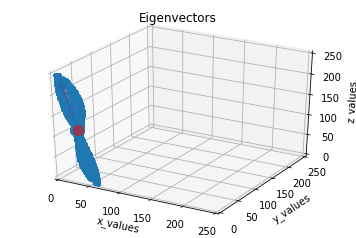

In [161]:
fig = plt.figure()

ax = fig.add_subplot(111, projection = '3d')
#ax.scatter(x_coord, y_coord, z_coord) # marche aussi

#ax.scatter(propeller_coords["X"], propeller_coords["Y"], propeller_coords["Z"])

# markersize et alpha contrôlent la taille des points, i.e. le rendering de l'objet
ax.plot(propeller_coords["X"], propeller_coords["Y"], propeller_coords["Z"], 'o', markersize=3, alpha=0.2)

downlim, uplim = findMinMaxDF(propeller_coords)

ax.plot([np.mean(propeller_coords["X"])], [np.mean(propeller_coords["Y"])], [np.mean(propeller_coords["Z"])],
        'o', markersize=10, color='red', alpha=0.5)

#for v in eigenvectors.T:
a = Arrow3D([np.mean(propeller_coords["X"]), np.mean(propeller_coords["X"]) + vect_upper[0]], 
            [np.mean(propeller_coords["Y"]), np.mean(propeller_coords["Y"]) + vect_upper[1]], 
            [np.mean(propeller_coords["Z"]), np.mean(propeller_coords["Z"]) + vect_upper[2]], 
            mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
ax.add_artist(a)

ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

ax.set_xlim([downlim, uplim]);
ax.set_ylim([downlim, uplim]);
ax.set_zlim([downlim, uplim]);

plt.title('Eigenvectors')

plt.show()